# (Pretty Much) Following the Kaggle Tutorial

We work with a dataset containing 25,000 movie reviews from IMDB, labeled by sentiment (positive/negative).  In addition, there are another 50,000 IMDB reviews provided without any rating labels.  

The reviews are split evenly into train and test sets (25k train and 25k test). The overall distribution of labels is also balanced within the train set (12.5k pos and 12.5k neg).  Our goal is to see how well we can predict sentiment in the test dataset. 

We note that Keras also has a version of this dataset, but it is missing the unlabeled reviews.  We could download the original dataset [here](http://ai.stanford.edu/~amaas/data/sentiment/), but we settle on a slighly more formatted (and so easier-to-use) version from Kaggle [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/data?unlabeledTrainData.tsv.zip).

For this first part of the notebook, we follow along with the Kaggle tutorial [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words).

In [1]:
import pandas as pd                 # for importing the data
from bs4 import BeautifulSoup       # for removing HTML tags
import re                           # for processing with regular expressions
import nltk.data                    # for sentence splitting
import logging                      # output messages for word2vec embedding step
from gensim.models import word2vec  # embedding algorithm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# If you are using Python 3, you will get an error.
# (Pattern is a Python 2 library and fails to install for Python 3.)

/Users/alexis/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
# load the data
train = pd.read_csv("../data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("../data/testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv("../data/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

Here, `train` is a pandas dataframe with 25,000 rows, each corresponding to a review.  There are three columns:
- `id`: an identifier
- `sentiment` $\in \{0,1\}$: indicates pos(1) or neg(0) sentiment
- `review`: the full text of the review

`test` and `unlabeled_train` have 25,000 and 50,000 rows, respectively, and each contain two columns (`id` and `review`).

In [3]:
print("Read %d labeled train reviews, %d test reviews, " \
 "and %d unlabeled train reviews.\n" % (train["review"].size,  
 test["review"].size, unlabeled_train["review"].size))
print("TOTAL: %d reviews.\n" % int(train["review"].size + test["review"].size + unlabeled_train["review"].size))
print("In the labeled train set, %s reviews are positive, and %s are negative." % (sum(train["sentiment"].values), train.shape[0]-sum(train["sentiment"].values)))

Read 25000 labeled train reviews, 25000 test reviews, and 50000 unlabeled train reviews.

TOTAL: 100000 reviews.

In the labeled train set, 12500 reviews are positive, and 12500 are negative.


We visualize a sample review below.  

In [6]:
train["review"][2]

'"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature\'s most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight against 

We would like to process each review to make it mathematically digestible.  We focus on using distributed word vectors created by the Word2Vec algorithm.  We use the implementation of Word2Vec from the gensim package.

Word2Vec takes as input single sentences, each one as a list of words.  That is, the input format is a list of lists.  It outputs a model of semantic meaning. 

We split a paragraph into sentences through the use of NLTK's __punkt__ tokenizer.  As an example, we print the first sentence identified by __punkt__ from the review above.  It nicely corresponds to our expectations!

In [7]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Convert sample review to list of sentences
stripped_sentences_sample = tokenizer.tokenize(train['review'][2].strip())
# Visualize first sample sentence
print(stripped_sentences_sample[0])

"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park .


We would furthermore need each sentence to be cleaned.  There are HTML tags such as `<br/>`, abbreviations, punctuation - all common issues when processing text from online. We need to tidy up the text before applying machine learning algorithms.

Our function `raw_sentence_to_wordlist` works as follows:
- HTML tags are removed through the use of the Beautiful Soup library.
- Numbers and punctuation are replaced with a space using regular expressions.
- We convert all of the words to lowercase and convert the sentence string into a list of words.

In [18]:
def raw_sentence_to_wordlist( raw_sentence ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_sentence, "lxml").get_text() 
    #
    # 2. Remove non-letters (replace numbers and punctuation, for instance, with a space)      
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    wordlist = letters_only.lower().split()                             
    #
    # 4. Return a list of words.
    return(wordlist)   

As an example, we output the cleaned version of the sentence above.  Again, it appears to be working nicely!

In [19]:
print(raw_sentence_to_wordlist(stripped_sentences_sample[0]))

['the', 'film', 'starts', 'with', 'a', 'manager', 'nicholas', 'bell', 'giving', 'welcome', 'investors', 'robert', 'carradine', 'to', 'primal', 'park']


We are almost done with processing the input for the Word2Vec embedding.  Now, we need only create a function (here, `review_to_sentences`) that puts everything together by looping through the paragraph and creates lists of lists of clean sentences.

In [20]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( raw_sentence_to_wordlist( raw_sentence ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

We now need only to call this function to populate our list of lists.

In [182]:
# I chose not to use the tqdm package here, but it is a possibility for tracking longer runtimes.
train_sentences = []  # Initialize an empty list of sentences
unlabeled_sentences = []
labels = []

print("Parsing sentences from training set")
for index, row in train.iterrows():
    to_append = review_to_sentences(train['review'][index], tokenizer)
    train_sentences += to_append
    labels += list(train['sentiment'][index]*np.ones(len(to_append)))

print("Parsing sentences from unlabeled set")
for index, row in unlabeled_train.iterrows():
    to_append = review_to_sentences(unlabeled_train['review'][index], tokenizer)
    unlabeled_sentences += to_append

# concatenate the two lists
sentences = train_sentences + unlabeled_sentences

The Word2Vec algorithm accepts a number of parameters that must be trained.  Here, we provide some starting points (that were supplied by the writers of the Kaggle tutorial).

In [22]:
# OPTIONAL: Configure logging module so that Word2Vec creates nice output messages
# I chose not to use it, because it runs quite fast on my system.
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and save the model for later use. 
# model.save("300features_40minwords_10context")
# to load: model = Word2Vec.load("300features_40minwords_10context")

We can use the `most_similar` function to get insight into the model's word clusters.  This function returns the words that are closest to the provided word.

In [11]:
model.most_similar("bad")

[('terrible', 0.6697828769683838),
 ('horrible', 0.646095871925354),
 ('good', 0.6342213153839111),
 ('lousy', 0.6001288890838623),
 ('awful', 0.5992096662521362),
 ('crappy', 0.5987610816955566),
 ('stupid', 0.5869919061660767),
 ('cheesy', 0.5790674686431885),
 ('lame', 0.5578579306602478),
 ('dumb', 0.5522592067718506)]

It seems we have a reasonably good model for semantic meaning :).  In case you're wondering how the model is stored, we can look beneath the hood.  The Word2Vec model consists of a feature vector for each word in the vocabulary, stored in a numpy array called "syn0".

In [12]:
print(type(model.syn0))
print(model.syn0.shape)

<class 'numpy.ndarray'>
(16490, 300)


Individual word vectors can be accessed in the following way:

In [13]:
# Each word is assinged a 1x300 numpy array
print(model["bad"].shape)

# As an example, we output the first 5 entries of the array assigned to "bad" 
print(model["bad"][:5])

(300,)
[ 0.04584237 -0.10387777 -0.07895309  0.07299399  0.061274  ]


We now have a representation of each document, with the $i$-th document as a matrix with 300 columns and $w_i$ rows, where $w_i$ is the number of words in the $i$-th document.  Unlike the bag-of-words representation, this embedding captures the dynamics of word order and represents a useful improvement that could be fed into a potential classification algorithm.

However, we soon run into a problem.  Classification and clustering algorithms typically require the text input to be represented as a fixed length vector.  The Kaggle tutorial investigates two methods to deal with this issue.  The resultant test accuracy was then compared to the results of simply running a Random Forest classifer on bag-of-words features.

The first method was to simply average the word vectors in a given review; they also removed stop words in processing.  The resultant set of average word vectors was then fed into a Random Forest classifier.  This method (slightly) underperformed bag-of-words.

The second method was to cluster the set of words, according to their Word2Vec embeddings.  They used $K$-means for this purpose, with the number of clusters set to one fifth of the vocabulary size ($K$ = 16490/5 = 3298).  Documents were then represented as "bags-of-centroids", where each document was represented as a $K$-dimensional vector, where the $i$-th entry contained the number of words in the document in the $i$-th cluster.  The resultant bag-of-centroids vectors were then fed into a Random Forest classifier.  This method (slightly) underperformed bag of words.

Thus, we must find a more clever approach towards using our Word2Vec features. 

# Deviating from Kaggle Tutorial

In [176]:
# obtain shortest and longest sentences
(max_sentence_id, longest_sentence) = max(enumerate(sentences), key = lambda sentences: len(sentences[1]))
(min_sentence_id, shortest_sentence) = min(enumerate(sentences), key = lambda sentences: len(sentences[1]))

print("The longest sentence has %s words." % len(longest_sentence))
print("The shortest sentence has %s words." % len(shortest_sentence))

num_classes = len(train['sentiment'].unique())
print("We have a total of %s classes." % num_classes)
print(shortest_sentence)

embedding_size = 100
vocab_size = 1000
sequence_length = 80

The longest sentence has 969 words.
The shortest sentence has 0 words.
We have a total of 2 classes.
[]


Total number of sentences: 795538
Total number of labeled sentences: 266551
Total number of unlabeled sentences: 528987
Sentences of length 0: 4468
Sentences of length >200: 445 ( <=200: 795093 )

Sentences of length >100: 5404 ( <=100: 790134 )



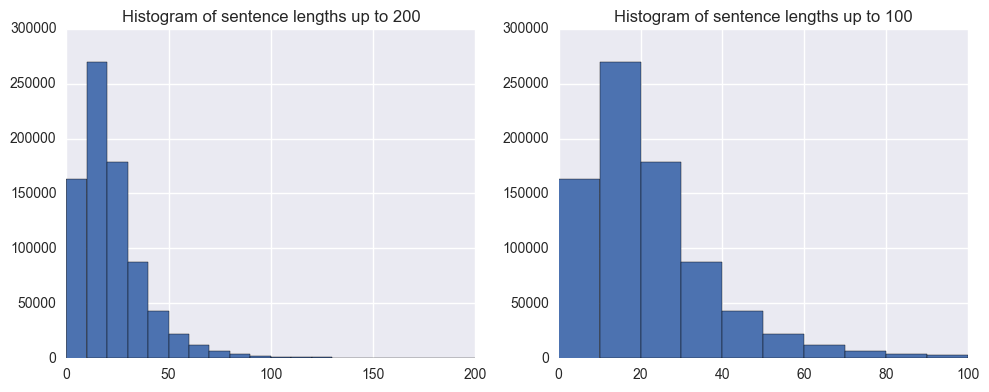

In [184]:
# obtain list of sentence lengths
sentence_lengths = [len(elem) for elem in sentences]
sentence_lengths.sort()

# get total number of sentences
print("Total number of sentences:", len(sentence_lengths))
print("Total number of labeled sentences:", len(train_sentences))
print("Total number of unlabeled sentences:", len(unlabeled_sentences))
# get number of sentences of length zero
print("Sentences of length 0:", sum([i==0 for i in sentence_lengths]))
# get number of sentences of size greater than 200
print("Sentences of length >200:", sum([i>200 for i in sentence_lengths]), 
      "( <=200:", sum([i<=200 for i in sentence_lengths]), ")\n")
# get number of sentences of size greater than 100
print("Sentences of length >100:", sum([i>100 for i in sentence_lengths]), 
      "( <=100:", sum([i<=100 for i in sentence_lengths]), ")\n")

# make plots
plt.figure(figsize=(10,4))

# make histogram of sentence lengths for sentences <=200 
plt.subplot(121)
plt.hist(sentence_lengths, bins=np.linspace(0, 200, 21))
plt.title("Histogram of sentence lengths up to 200")

# make histogram of sentence lengths for sentences <=100 
plt.subplot(122)
plt.hist(sentence_lengths, bins=np.linspace(0, 100, 11))
plt.title("Histogram of sentence lengths up to 100")

# adjust spacing between subplots to minimize the overlaps
plt.tight_layout()
plt.show()

In [137]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, model, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        
        # save the model
        self.model = model

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            # set embeddings
            W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W", trainable=False)
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # CalculateMean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [136]:
with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Initialize all variables
        sess.run(tf.initialize_all_variables())
        sess.run(cnn.W.assign(cnn.model.syn0))

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")

NameError: name 'x_train' is not defined

266551
266551
